In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Function to initialize the simulation domain
def initialize_domain(Nx, Ny, cylinder_center, cylinder_radius):
    # Initialize velocity fields
    # u: horizontal component of velocity, initially set to uniform flow
    # v: vertical component of velocity, initially zero
    # p: pressure field, initially zero
    u = np.full((Nx, Ny), 1.0)  # Set initial horizontal flow to 1.0
    v = np.zeros((Nx, Ny))      # No initial vertical flow
    p = np.zeros((Nx, Ny))      # Pressure field starts at zero

    # Creating a mask for the cylinder within the flow
    Y, X = np.ogrid[:Nx, :Ny]
    mask = (X - cylinder_center[0])**2 + (Y - cylinder_center[1])**2 <= cylinder_radius**2
    u[mask] = 0  # Zero velocity inside the cylinder
    v[mask] = 0  # No vertical movement inside the cylinder

    return u, v, p, mask

# Function to update the velocity in the domain
def update_velocity(u, v, p, dx, dy, dt, nu, rho, cylinder_mask):
    u_next = u.copy()  # Preparing next time step's velocity field
    v_next = v.copy()

    # Calculate higher-order advection terms
    du_dx, du_dy, dv_dx, dv_dy = higher_order_advection(u, v, dx, dy, dt)

    # Iterate over the grid (excluding boundaries)
    for i in range(1, u.shape[0]-1):
        for j in range(1, u.shape[1]-1):
            if not cylinder_mask[i, j]:  # Skip cylinder area
                # Compute pressure gradient
                dp_dx = (p[i+1, j] - p[i-1, j]) / (2 * dx)
                dp_dy = (p[i, j+1] - p[i, j-1]) / (2 * dy)

                # Update velocities (Navier-Stokes equations)
                # - Advection
                # - Pressure gradient
                # - Diffusion (viscosity)
                u_next[i, j] = (u[i, j] - u[i, j] * dt * du_dx[i, j] - v[i, j] * dt * du_dy[i, j] -
                               dt * dp_dx / rho + nu * dt * ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                               (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2))

                v_next[i, j] = (v[i, j] - u[i, j] * dt * dv_dx[i, j] - v[i, j] * dt * dv_dy[i, j] -
                               dt * dp_dy / rho + nu * dt * ((v[i+1, j] - 2*v[i, j] + v[i-1, j]) / dx**2 +
                               (v[i, j+1] - 2*v[i, j] + v[i, j-1]) / dy**2))

    # Enforce zero velocity in the cylinder area for next time step
    u_next[cylinder_mask] = 0
    v_next[cylinder_mask] = 0

    return u_next, v_next


def update_pressure(p, u, v, dx, dy, dt, rho, cylinder_mask):
    p_next = p.copy()

    # Pressure update (Poisson equation)
    for i in range(1, p.shape[0]-1):
        for j in range(1, p.shape[1]-1):
            if not cylinder_mask[i, j]:
                # Discretization for pressure update
                p_next[i, j] = (((p[i+1, j] + p[i-1, j]) * dy**2 + 
                                 (p[i, j+1] + p[i, j-1]) * dx**2 -
                                 rho * ((u[i+1, j] - u[i-1, j]) / (2 * dx) + 
                                        (v[i, j+1] - v[i, j-1]) / (2 * dy))**2 * dx**2 * dy**2) /
                                (2 * (dx**2 + dy**2)))

    return p_next

def higher_order_advection(u, v, dx, dy, dt):
    # Create arrays for the higher-order derivatives
    du_dx = np.zeros_like(u)
    du_dy = np.zeros_like(u)
    dv_dx = np.zeros_like(v)
    dv_dy = np.zeros_like(v)
    
    # Up-flow scheme for u component
    for i in range(1, u.shape[0]-1):
        for j in range(1, u.shape[1]-1):
            if u[i, j] > 0:  # Flow moving to the right
                du_dx[i, j] = (u[i, j] - u[i-1, j]) / dx
            else:  # Flow moving to the left
                du_dx[i, j] = (u[i+1, j] - u[i, j]) / dx

            if v[i, j] > 0:  # Flow moving upwards
                du_dy[i, j] = (u[i, j] - u[i, j-1]) / dy
            else:  # Flow moving downwards
                du_dy[i, j] = (u[i, j+1] - u[i, j]) / dy
                
    return du_dx, du_dy, dv_dx, dv_dy




Reynolds Number: 811200.0


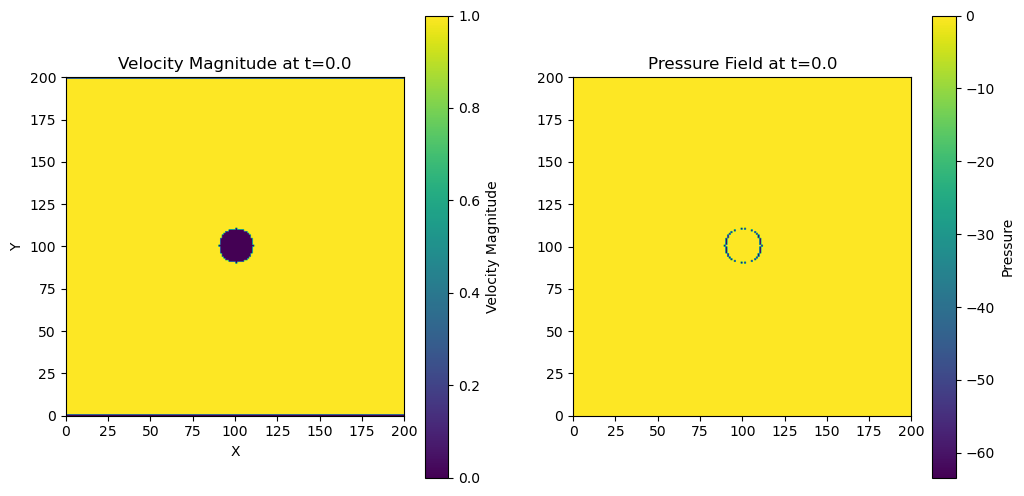

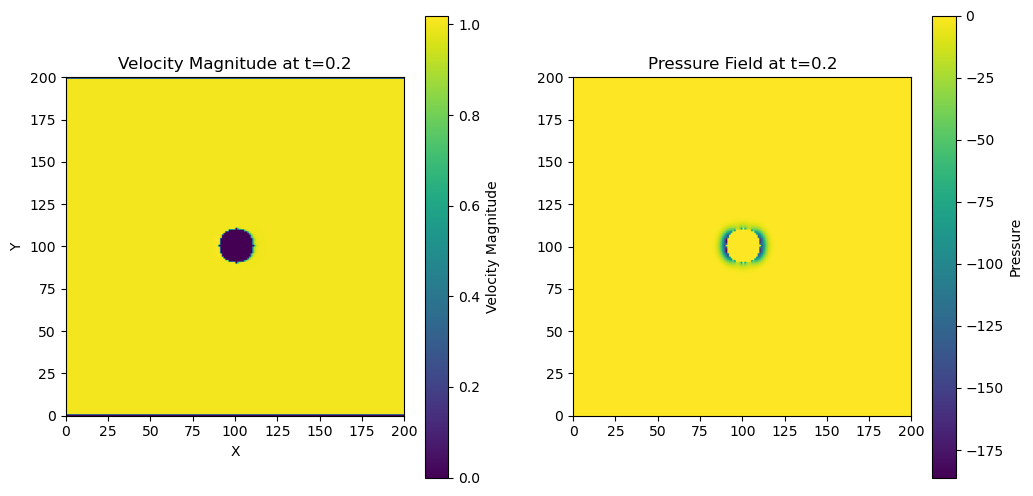

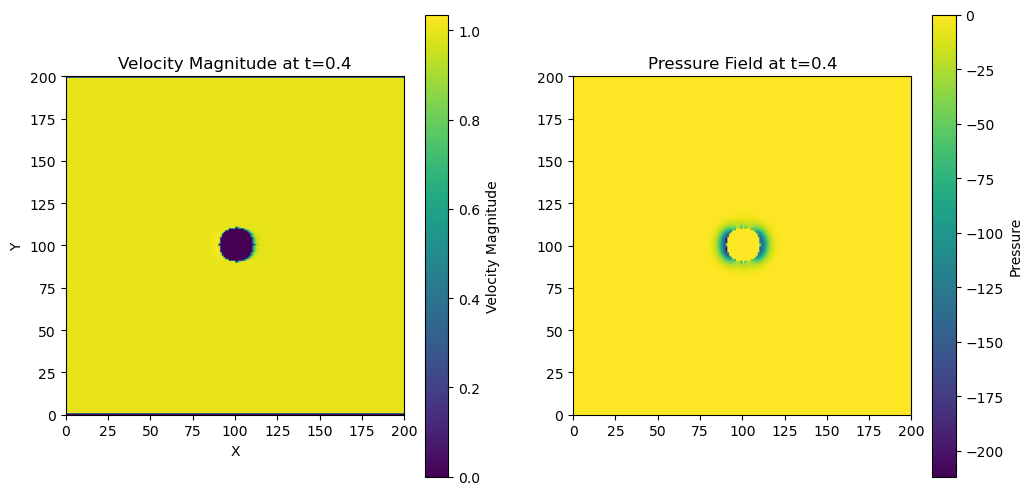

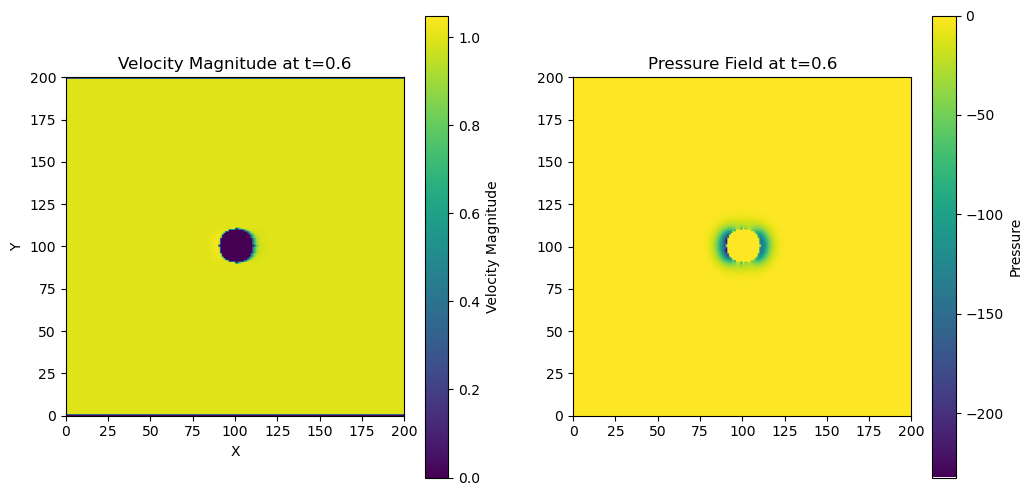

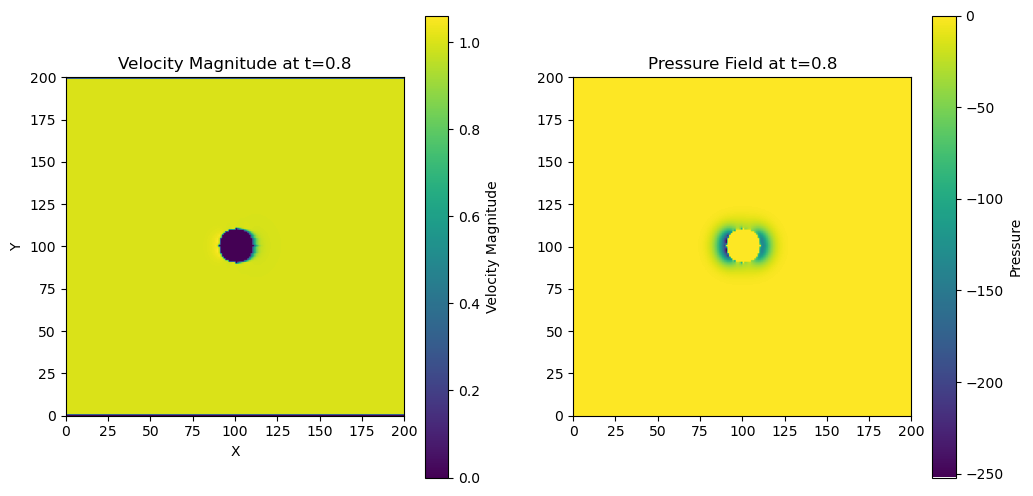

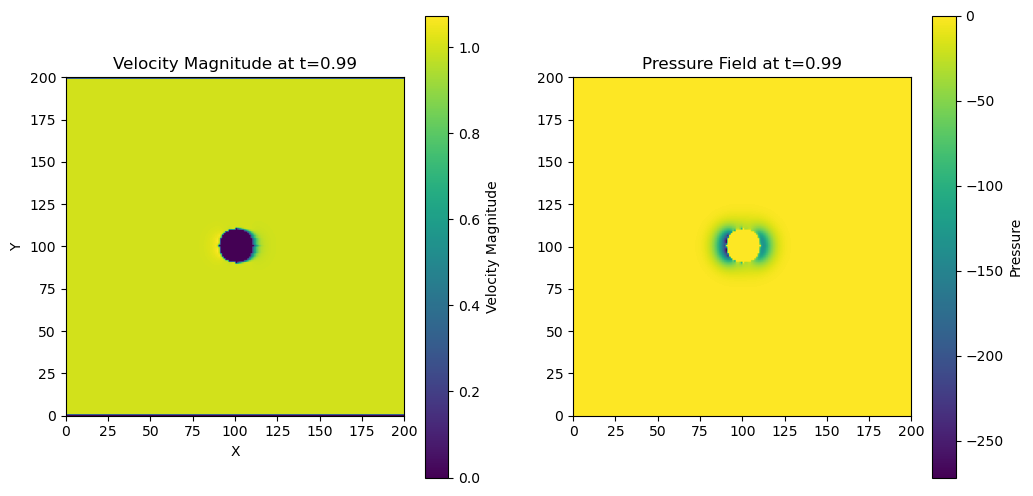

In [77]:
import matplotlib.pyplot as plt
import numpy as np

Nx, Ny = 200, 200
dx, dy = 0.5,  0.5
dt = 0.01
nu = 0.51
rho = 1014.0
cylinder_center = (100, Ny // 2)
cylinder_radius = 10
plot_interval = 20  # Interval at which to plot the fields

# Define fluid properties and flow characteristics
U = 4.0    # Characteristic velocity (m/s)
D = 2.0   # Diameter of the cylinder (m)
mu = 0.01  # Dynamic viscosity (Pa.s)
nu = mu / rho  # Update this based on your target Reynolds number
# Calculate the Reynolds number
Re = rho * U * D / mu
nt = 100

# Print the Reynolds number
print("Reynolds Number:", Re)

# Initialize the flow field
u, v, p, cylinder_mask = initialize_domain(Nx, Ny, cylinder_center, cylinder_radius)

for t in range(nt):
    u, v = update_velocity(u, v, p, dx, dy, dt, nu, rho, cylinder_mask)
    p = update_pressure(p, u, v, dx, dy, dt, rho, cylinder_mask)

    # Apply boundary conditions
    u[0, :] = 1.0  # Uniform flow at the inlet
    u[-1, :] = u[-2, :]  # Open boundary at the outlet
    u[:, 0] = u[:, -1] = 0  # No-slip at the top and bottom
    u[cylinder_mask] = 0  # No-slip on the cylinder
    v[cylinder_mask] = 0

    if t % plot_interval == 0 or t == nt - 1:
        # Plotting
        plt.figure(figsize=(12, 6))

        # Velocity magnitude plot
        velocity_magnitude = np.sqrt(np.transpose(u)**2 + np.transpose(v)**2)
        plt.subplot(1, 2, 1)
        plt.imshow(velocity_magnitude, origin='lower', cmap='viridis', extent=[0, Nx, 0, Ny])
        plt.colorbar(label='Velocity Magnitude')
        plt.title(f"Velocity Magnitude at t={t*dt}")
        plt.xlabel('X')
        plt.ylabel('Y')

        # Pressure plot
        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(p), origin='lower', cmap='viridis', extent=[0, Nx, 0, Ny])
        plt.colorbar(label='Pressure')
        plt.title(f"Pressure Field at t={t*dt}")

        plt.show()
